# DATA PROCESSING AND CLEANING

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install highlight_text
# !pip install pygwalker
# import pygwalker as pyg

import pandas as pd
import numpy as np
from sklearn import preprocessing
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from highlight_text import fig_text
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

  Using cached highlight_text-0.2-py3-none-any.whl.metadata (13 kB)
Using cached highlight_text-0.2-py3-none-any.whl (11 kB)


# 0. Helper Functions

In [ ]:
def missing_value_percent(df):
  """
  Calculates missing value percent for each column for a dataframe.
  """
  percent_missing = df.isnull().sum() * 100 / len(df)
  return percent_missing


In [ ]:
def compare_columns(df1, df2, col1, col2):
  """
  Compares common and uncommon elements in given columns for two dataframes.

  Args:
    df1: First DataFrame.
    df2: Second DataFrame.
    col1: Column name in df1.
    col2: Column name in df2.
  """
  # Find common elements
  common_elements = set(df1[col1].unique()).intersection(set(df2[col2].unique()))
  print(f"Common elements in df1.{col1} and df2.{col2}: {len(common_elements)}")

  # Find elements in df1[col1] but not in df2[col2]
  uncommon_elements_df1 = set(df1[col1].unique()) - set(df2[col2].unique())
  print(f"Elements in df1.{col1} but not in df2.{col2}: {uncommon_elements_df1}")

  # Find elements in df2[col2] but not in df1[col1]
  uncommon_elements_df2 = set(df2[col2].unique()) - set(df1[col1].unique())
  print(f"Elements in df2.{col2} but not in df1.{col1}: {uncommon_elements_df2}")

In [ ]:
# Function to convert percentage strings to float values
def convert_percentage_to_float(value):
  if isinstance(value, str) and '%' in value:
    try:
      return round(float(value.replace('%', '')) / 100, 4)
    except ValueError:
      return value
  else:
    return value

In [ ]:
index = pd.read_csv('/content/drive/MyDrive/thesis_data/company_index.csv', header=0)
index.head()

,ticker,permno,company,sector,subsector
0,AAPL,14593.0,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
1,ADBE,75510.0,Adobe Inc.,Information Technology,Application Software
2,ADI,60871.0,Analog Devices,Information Technology,Semiconductors
3,ADP,26331.0,ADP,Information Technology,Data Processing & Outsourced Services
4,ALGN,88860.0,Align Technology,Health Care,Health Care Supplies


In [ ]:
index['ticker'] = index['ticker'].replace('GOOG', 'GOOGL')

In [ ]:
index.permno = index.permno.astype(int) # Convert PERMNO column to integers
index_dict = dict(zip(index.ticker, index.permno)) # Create dictionary from two columns
print(f"Number of unique PERMNO: {index.permno.nunique()}")
print(index_dict)


Number of unique PERMNO: 56
{'AAPL': 14593, 'ADBE': 75510, 'ADI': 60871, 'ADP': 26331, 'ALGN': 88860, 'AMAT': 14702, 'AMD': 61241, 'AMGN': 14008, 'ANSS': 83621, 'ASML': 81472, 'AVGO': 88618, 'BIDU': 90857, 'CHTR': 87378, 'CRWD': 18726, 'CSCO': 76076, 'CTSH': 86158, 'DDOG': 18911, 'DOCU': 85819, 'DXCM': 90664, 'EA': 38543, 'FISV': 10696, 'FTNT': 93132, 'GILD': 40361, 'GOOGL': 90319, 'IDXX': 76709, 'ILMN': 88446, 'INTC': 59328, 'INTU': 78975, 'ISRG': 88352, 'KLAC': 46886, 'LRCX': 48486, 'MCHP': 78987, 'META': 76947, 'MRNA': 18312, 'MRVL': 88360, 'MSFT': 10107, 'MTCH': 10973, 'NFLX': 89393, 'NTES': 88362, 'NVDA': 86580, 'NXPI': 12084, 'OKTA': 16649, 'PAYX': 61621, 'PYPL': 89311, 'QCOM': 77178, 'REGN': 76614, 'SGEN': 88949, 'SNPS': 77357, 'SPLK': 83419, 'TEAM': 11910, 'TXN': 15579, 'VRSN': 85753, 'VRTX': 81227, 'WDAY': 13628, 'ZM': 18484, 'ZS': 17341}


# 1. Financial Data
Drag and drop the financial_ratios CSV file to begin running the below cells.

## 1.1 Fundamentals Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/thesis_data/fin_ratios3.csv', header=0)
# data = data.dropna()
print(data.shape)
print(list(data.columns))

(4012, 47)
['gvkey', 'permno', 'adate', 'qdate', 'public_date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'ptb', 'PEG_trailing', 'divyield', 'TICKER', 'cusip']


In [ ]:
data.TICKER.unique()

array(['MSFT', 'FISV', 'TEAM', 'WDAY', 'AMGN', 'AAPL', 'AMAT', 'TXN',
       'OKTA', nan, 'ZS', 'MRNA', 'ZM', 'CRWD', 'DDOG', 'KLAC', 'LRCX',
       'INTC', 'ADI', 'AMD', 'PAYX', 'ADBE', 'CSCO', 'REGN', 'IDXX',
       'QCOM', 'SNPS', 'INTU', 'MCHP', 'ANSS', 'VRSN', 'CTSH', 'NVDA',
       'ISRG', 'ILMN', 'ALGN', 'SGEN', 'NFLX', 'GOOG', 'GOOGL', 'DXCM',
       'FTNT'], dtype=object)

In [ ]:
tickers = data.TICKER.unique()
print(tickers, len(tickers))
# Get sector information
for ticker in tickers:
  print(ticker)
  try:
    yfinance = yf.Ticker(ticker)
    data.loc[data['TICKER'] == ticker, 'sector'] = yfinance.info.get('sector')
    # print(f"{ticker}:{yfinance.info.get('sector')}")
    if yfinance.info.get('sector') == None:
      raise Exception('None type sector found')
  except:
    # As SGEN was recently acquired by Pfizer and is not listed on Yahoo post 2023
    if ticker == 'SGEN':
      data.loc[data['TICKER'] == ticker, 'sector'] = 'Healthcare'
      # print(f"{ticker}:Healthcare")
  else:
    # print(ticker)
    continue

['MSFT' 'FISV' 'TEAM' 'WDAY' 'AMGN' 'AAPL' 'AMAT' 'TXN' 'OKTA' nan 'ZS'
 'MRNA' 'ZM' 'CRWD' 'DDOG' 'KLAC' 'LRCX' 'INTC' 'ADI' 'AMD' 'PAYX' 'ADBE'
 'CSCO' 'REGN' 'IDXX' 'QCOM' 'SNPS' 'INTU' 'MCHP' 'ANSS' 'VRSN' 'CTSH'
 'NVDA' 'ISRG' 'ILMN' 'ALGN' 'SGEN' 'NFLX' 'GOOG' 'GOOGL' 'DXCM' 'FTNT'] 42
MSFT
FISV
TEAM
WDAY
AMGN
AAPL
AMAT
TXN
OKTA
nan
ZS
MRNA
ZM
CRWD
DDOG
KLAC
LRCX
INTC
ADI
AMD
PAYX
ADBE
CSCO
REGN
IDXX
QCOM
SNPS
INTU
MCHP
ANSS
VRSN
CTSH
NVDA
ISRG
ILMN
ALGN
SGEN
NFLX
GOOG
GOOGL
DXCM
FTNT


In [ ]:
# Percentage distribution
(data.sector.value_counts()/sum(data.sector.value_counts()))*100

,count
sector,
Technology,68.807811
Healthcare,24.948613
Communication Services,6.166495
nan,0.077081


In [ ]:
data.head()

,gvkey,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,...,sale_invcap,sale_equity,sale_nwc,rd_sale,ptb,PEG_trailing,divyield,TICKER,cusip,sector
0,12141,10107,2009-06-30,2009-09-30,2010-01-31,17.445,0.181,9.091,17.835,17.949,...,1.410,1.480,2.938,0.156,5.975,2.039,1.85%,MSFT,59491810,Technology
1,12141,10107,2009-06-30,2009-12-31,2010-02-28,17.365,0.166,9.138,15.332,15.582,...,1.355,1.449,2.626,0.146,5.630,0.910,1.81%,MSFT,59491810,Technology
2,12141,10107,2009-06-30,2009-12-31,2010-03-31,17.722,0.166,9.138,15.662,15.917,...,1.355,1.449,2.626,0.146,5.746,0.930,1.78%,MSFT,59491810,Technology
3,12141,10107,2009-06-30,2009-12-31,2010-04-30,18.480,0.166,9.138,16.329,16.595,...,1.355,1.449,2.626,0.146,5.992,0.970,1.70%,MSFT,59491810,Technology
4,12141,10107,2009-06-30,2010-03-31,2010-05-31,15.296,0.181,9.939,13.163,13.368,...,1.282,1.395,2.368,0.144,4.859,1.119,2.02%,MSFT,59491810,Technology


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012 entries, 0 to 4011
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gvkey           4012 non-null   int64  
 1   permno          4012 non-null   int64  
 2   adate           4012 non-null   object 
 3   qdate           4012 non-null   object 
 4   public_date     4012 non-null   object 
 5   CAPEI           3966 non-null   float64
 6   bm              3865 non-null   float64
 7   evm             4012 non-null   float64
 8   pe_op_basic     4008 non-null   float64
 9   pe_op_dil       4008 non-null   float64
 10  pe_exi          4009 non-null   float64
 11  pe_inc          4009 non-null   float64
 12  ps              4012 non-null   float64
 13  pcf             4012 non-null   float64
 14  dpr             3498 non-null   float64
 15  npm             4012 non-null   float64
 16  opmbd           4012 non-null   float64
 17  opmad           4012 non-null   f

In [ ]:
data['public_date'] = pd.to_datetime(data['public_date'])
data = data.drop(['adate', 'qdate'], axis=1)

In [ ]:
def reindex_dates(df, date_col):
  df.index = df[date_col]
  # identifiers to refill
  permno = df.permno.iloc[0]
  gvkey = df.gvkey.iloc[0]
  ticker = df.TICKER.iloc[0]
  # cusip = df.cusip.iloc[0]
  # date range as index
  df = df.sort_index()
  start = pd.Timestamp(year=2010, month=1, day=31).to_datetime64()
  end = pd.Timestamp(year=2019, month=12, day=31).to_datetime64()
  new_dates = pd.date_range(start=start,end=end,freq='M')
  # reindex
  df = df.reindex(new_dates)
  df = df.rename_axis('date')
  df.reset_index(inplace=True)
  # reset identifiers for new rows
  df.permno = permno
  df.gvkey = gvkey
  df.TICKER = ticker
  # df.cusip = cusip
  df = df.drop(['public_date'], axis=1)
  # print(ticker)
  return df

fin_monthly_df = data.groupby('TICKER').apply(reindex_dates, ('public_date'))
fin_monthly_df.reset_index(drop=True, inplace=True)
fin_monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4920 non-null   datetime64[ns]
 1   gvkey           4920 non-null   int64         
 2   permno          4920 non-null   int64         
 3   CAPEI           3966 non-null   float64       
 4   bm              3864 non-null   float64       
 5   evm             4009 non-null   float64       
 6   pe_op_basic     4005 non-null   float64       
 7   pe_op_dil       4005 non-null   float64       
 8   pe_exi          4006 non-null   float64       
 9   pe_inc          4006 non-null   float64       
 10  ps              4009 non-null   float64       
 11  pcf             4009 non-null   float64       
 12  dpr             3497 non-null   float64       
 13  npm             4009 non-null   float64       
 14  opmbd           4009 non-null   float64       
 15  opma

In [ ]:
# Drop if TICKER, permno, and gvkey are None
fin_monthly_df = fin_monthly_df.dropna(subset=['TICKER', 'gvkey'], how="all")

fin_permno = fin_monthly_df.permno.unique()
fin_gvkey = fin_monthly_df.gvkey.unique()
fin_tickers = fin_monthly_df.TICKER.unique()
data_tickers = data.TICKER.unique()

compare_columns(fin_monthly_df, data, 'TICKER', 'TICKER')

Common elements in df1.TICKER and df2.TICKER: 41
Elements in df1.TICKER but not in df2.TICKER: set()
Elements in df2.TICKER but not in df1.TICKER: {nan}


### Fix Google double ticker discrepancy [GOOG, GOOGL]

In [ ]:
# Filter data for 'GOOG' and 'GOOGL'
goog_googl_df = fin_monthly_df[fin_monthly_df['TICKER'].isin(['GOOG', 'GOOGL'])]

# Missing values count by column
print(goog_googl_df[goog_googl_df['TICKER']=='GOOG'].isnull().sum())

date                0
gvkey               0
permno              0
CAPEI              65
bm                 65
evm                65
pe_op_basic        65
pe_op_dil          65
pe_exi             65
pe_inc             65
ps                 65
pcf                65
dpr                65
npm                65
opmbd              65
opmad              65
gpm                65
ptpm               65
roa                65
roe                65
roce               65
efftax             65
aftret_eq          65
aftret_invcapx     65
aftret_equity      65
pretret_noa        65
pretret_earnat     65
GProf              65
equity_invcap      65
debt_invcap        65
totdebt_invcap     65
capital_ratio      65
inv_turn           96
at_turn            65
rect_turn          65
pay_turn           65
sale_invcap        65
sale_equity        65
sale_nwc           65
rd_sale            65
ptb                65
PEG_trailing       65
divyield          120
TICKER              0
cusip              65
sector    

In [ ]:
goog_googl_df

,date,gvkey,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,...,sale_invcap,sale_equity,sale_nwc,rd_sale,ptb,PEG_trailing,divyield,TICKER,cusip,sector
1800,2010-01-31,160329,90319,41.714,0.215,13.444,1.544,1.556,1.712,1.712,...,0.735,0.735,1.085,0.125,3.833,0.061,NaN,GOOG,38259P50,Communication Services
1801,2010-02-28,160329,90319,32.988,0.183,20.012,25.486,25.735,25.811,25.811,...,0.657,0.657,0.895,0.120,3.572,0.888,NaN,GOOG,38259P50,Communication Services
1802,2010-03-31,160329,90319,35.615,0.183,20.012,27.437,27.705,27.786,27.786,...,0.657,0.657,0.895,0.120,3.857,0.956,NaN,GOOG,38259P50,Communication Services
1803,2010-04-30,160329,90319,33.116,0.183,20.012,25.433,25.681,25.757,25.757,...,0.657,0.657,0.895,0.120,3.586,0.886,NaN,GOOG,38259P50,Communication Services
1804,2010-05-31,160329,90319,32.047,0.212,16.136,1.091,1.105,1.105,1.105,...,0.714,0.714,0.992,0.121,3.116,0.039,NaN,GOOG,38259P50,Communication Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,2019-08-31,160329,90319,18.817,0.258,17.735,1.122,1.133,1.202,1.202,...,0.784,0.820,1.436,0.159,1.837,0.034,NaN,GOOGL,02079K30,Communication Services
2036,2019-09-30,160329,90319,19.307,0.258,17.735,1.151,1.162,1.232,1.232,...,0.784,0.820,1.436,0.159,1.885,0.035,NaN,GOOGL,02079K30,Communication Services
2037,2019-10-31,160329,90319,19.903,0.258,17.735,1.187,1.198,1.270,1.270,...,0.784,0.820,1.436,0.159,1.943,0.036,NaN,GOOGL,02079K30,Communication Services
2038,2019-11-30,160329,90319,19.643,0.233,17.175,1.287,1.298,1.399,1.399,...,0.784,0.829,1.463,0.160,1.986,0.057,NaN,GOOGL,02079K30,Communication Services


In [ ]:
# Filter 'GOOG'
goog_df = goog_googl_df[goog_googl_df['TICKER'] == 'GOOG']
goog_df = goog_df[goog_df['date'] <= '2014-08-01']

# Filter 'GOOGL'
googl_df = goog_googl_df[goog_googl_df['TICKER'] == 'GOOGL']
googl_df = googl_df[googl_df['date'] >= '2014-08-01']

# Concatenate the filtered DataFrames
new_goog_googl_df = pd.concat([goog_df, googl_df])
new_goog_googl_df['TICKER'] = new_goog_googl_df['TICKER'].replace('GOOG', 'GOOGL')
new_goog_googl_df.info()
fin_monthly_df[fin_monthly_df['TICKER'].isin(['GOOG', 'GOOGL'])] = new_goog_googl_df

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 1800 to 2039
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            120 non-null    datetime64[ns]
 1   gvkey           120 non-null    int64         
 2   permno          120 non-null    int64         
 3   CAPEI           120 non-null    float64       
 4   bm              120 non-null    float64       
 5   evm             120 non-null    float64       
 6   pe_op_basic     120 non-null    float64       
 7   pe_op_dil       120 non-null    float64       
 8   pe_exi          120 non-null    float64       
 9   pe_inc          120 non-null    float64       
 10  ps              120 non-null    float64       
 11  pcf             120 non-null    float64       
 12  dpr             120 non-null    float64       
 13  npm             120 non-null    float64       
 14  opmbd           120 non-null    float64       
 15  opmad  

### Create Month and Year columns

In [ ]:
# create month var
fin_monthly_df['month'] = fin_monthly_df['date'].dt.month

# create year var
fin_monthly_df['year'] = fin_monthly_df['date'].dt.year

In [ ]:
fin_monthly_df.groupby('TICKER')['year'].value_counts() == 12

TICKER  year  
AAPL    2010.0    True
        2011.0    True
        2019.0    True
        2018.0    True
        2017.0    True
                  ... 
ZS      2013.0    True
        2012.0    True
        2011.0    True
        2010.0    True
        2019.0    True
Name: count, Length: 400, dtype: bool

### Impute Missing Values

In [ ]:
calculate_missing_percent = missing_value_percent(fin_monthly_df)
print(calculate_missing_percent)

date               2.439024
gvkey              2.439024
permno             2.439024
CAPEI             19.390244
bm                21.463415
evm               18.516260
pe_op_basic       18.597561
pe_op_dil         18.597561
pe_exi            18.577236
pe_inc            18.577236
ps                18.516260
pcf               18.516260
dpr               28.922764
npm               18.516260
opmbd             18.516260
opmad             18.516260
gpm               18.516260
ptpm              18.516260
roa               18.516260
roe               22.012195
roce              19.410569
efftax            29.715447
aftret_eq         18.516260
aftret_invcapx    18.699187
aftret_equity     18.516260
pretret_noa       18.516260
pretret_earnat    18.516260
GProf             18.516260
equity_invcap     18.577236
debt_invcap       19.227642
totdebt_invcap    19.227642
capital_ratio     19.166667
inv_turn          42.560976
at_turn           18.516260
rect_turn         20.731707
pay_turn          19

In [ ]:
# Forward fill missing values by TICKER
fin_monthly_df = fin_monthly_df.set_index('TICKER').groupby(level='TICKER').ffill().reset_index()

In [ ]:
fin_monthly_df[fin_monthly_df['rd_sale'].isnull()].TICKER.unique()

array(['CRWD', 'DDOG', 'FTNT', nan, 'MRNA', 'OKTA', 'WDAY', 'ZM', 'ZS'],
      dtype=object)

In [ ]:
calculate_missing_percent = missing_value_percent(fin_monthly_df)
print(calculate_missing_percent)

TICKER             2.439024
date               2.439024
gvkey              2.439024
permno             2.439024
CAPEI             17.174797
bm                16.402439
evm               16.300813
pe_op_basic       16.300813
pe_op_dil         16.300813
pe_exi            16.300813
pe_inc            16.300813
ps                16.300813
pcf               16.300813
dpr               25.060976
npm               16.300813
opmbd             16.300813
opmad             16.300813
gpm               16.300813
ptpm              16.300813
roa               16.300813
roe               16.890244
roce              17.012195
efftax            25.833333
aftret_eq         16.300813
aftret_invcapx    16.422764
aftret_equity     16.300813
pretret_noa       16.300813
pretret_earnat    16.300813
GProf             16.300813
equity_invcap     16.300813
debt_invcap       16.890244
totdebt_invcap    16.890244
capital_ratio     16.890244
inv_turn          42.378049
at_turn           16.300813
rect_turn         18

## 1.2 OHLC Data
Manipulating OHLC data to derive monthly market valuation data

In [ ]:
ohlc_df = pd.read_csv('/content/drive/MyDrive/thesis_data/comp_daily_p.csv', header=0)
ohlc_df['date'] = pd.to_datetime(ohlc_df['datadate'])
ohlc_df.head()

,gvkey,iid,datadate,tic,cusip,conm,cshoc,cshtrd,prccd,prchd,prcld,prcod,busdesc,conml,date
0,1161,1,2010-01-04,AMD,007903107,ADVANCED MICRO DEVICES,670361000.0,18719210.0,9.70,9.90,9.68,9.79,"Advanced Micro Devices, Inc. operates as a sem...",Advanced Micro Devices Inc,2010-01-04
1,1161,1,2010-01-05,AMD,007903107,ADVANCED MICRO DEVICES,670361000.0,22109100.0,9.71,9.90,9.68,9.71,"Advanced Micro Devices, Inc. operates as a sem...",Advanced Micro Devices Inc,2010-01-05
2,1161,1,2010-01-06,AMD,007903107,ADVANCED MICRO DEVICES,670361000.0,18640620.0,9.57,9.76,9.55,9.68,"Advanced Micro Devices, Inc. operates as a sem...",Advanced Micro Devices Inc,2010-01-06
3,1161,1,2010-01-07,AMD,007903107,ADVANCED MICRO DEVICES,670361000.0,26793490.0,9.47,9.55,9.18,9.51,"Advanced Micro Devices, Inc. operates as a sem...",Advanced Micro Devices Inc,2010-01-07
4,1161,1,2010-01-08,AMD,007903107,ADVANCED MICRO DEVICES,670361000.0,13752150.0,9.43,9.47,9.29,9.37,"Advanced Micro Devices, Inc. operates as a sem...",Advanced Micro Devices Inc,2010-01-08


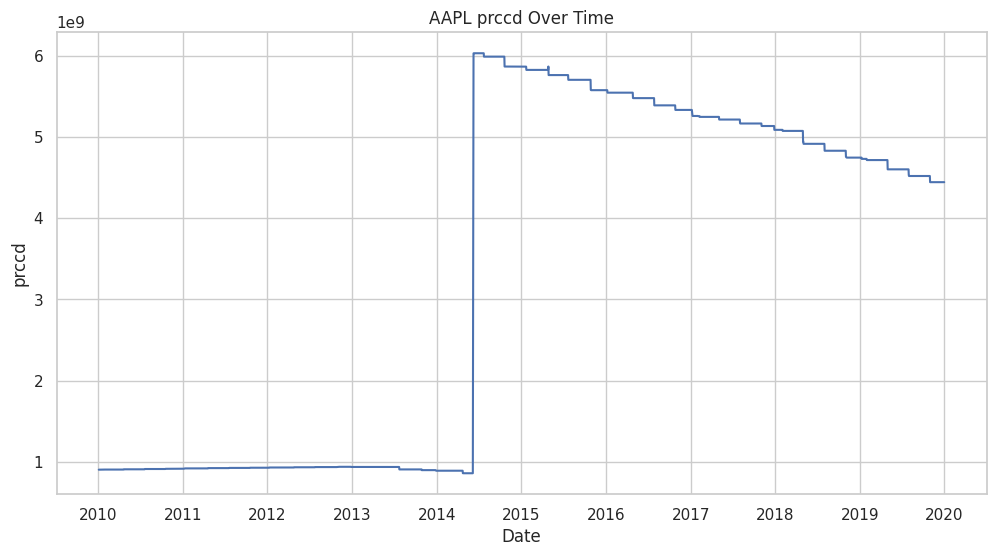

In [ ]:
# prompt: Plot prccd for the 'AAPL' tic using date

import matplotlib.pyplot as plt
# Filter data for 'AAPL'
aapl_df = ohlc_df[ohlc_df['tic'] == 'AAPL']

# Plot prccd over time
plt.figure(figsize=(12, 6))
plt.plot(aapl_df['date'], aapl_df['cshoc'])
plt.xlabel('Date')
plt.ylabel('prccd')
plt.title('AAPL prccd Over Time')
plt.grid(True)
plt.show()


In [ ]:
# Group by 'gvkey' and get the unique 'tic' values for each group
gvkey_tic_mapping = ohlc_df.groupby('gvkey')['tic'].unique()

# Find groups with more than one unique 'tic'
duplicate_tics = gvkey_tic_mapping[gvkey_tic_mapping.apply(lambda x: len(x) > 1)]

# Print the results
print(duplicate_tics)

gvkey
61214     [ASMLF, ASML]
160329    [GOOGL, GOOG]
180711    [AVGO, AVGOP]
Name: tic, dtype: object


In [ ]:
ohlc_tickers = ohlc_df['tic'].unique()
print(ohlc_tickers, len(ohlc_tickers))

['AMD' 'AMGN' 'ADI' 'AAPL' 'AMAT' 'ADP' 'INTC' 'KLAC' 'LRCX' 'PAYX' 'TXN'
 'MSFT' 'ADBE' 'WDAY' 'EA' 'CSCO' 'REGN' 'IDXX' 'VRTX' 'PYPL' 'QCOM'
 'GILD' 'SNPS' 'MTCH' 'TEAM' 'INTU' 'MCHP' 'OKTA' 'ZS' 'DOCU' 'MRNA' 'ZM'
 'CRWD' 'DDOG' 'ASMLF' 'ASML' 'ANSS' 'VRSN' 'CTSH' 'NVDA' 'CHTR' 'ISRG'
 'MRVL' 'NTES' 'ILMN' 'ALGN' 'SGEN' 'NFLX' 'GOOGL' 'GOOG' 'DXCM' 'BIDU'
 'SPLK' 'META' 'AVGO' 'AVGOP' 'FTNT' 'NXPI'] 58


We need to overcome the problem of multiple tickers for the same company as visible above.

### Fix double ticker discrepancy such as [GOOG, GOOGL]



In [ ]:
# Subset ohlc_df for 'tic' equal to 'GOOG' and 'GOOGL'
t_a, t_b = 'GOOG', 'GOOGL'
goog_googl_ohlc = ohlc_df[ohlc_df['tic'].isin([t_a, t_b])]
goog_googl_ohlc

,gvkey,iid,datadate,tic,cusip,conm,cshoc,cshtrd,prccd,prchd,prcld,prcod,busdesc,conml,date
101204,160329,1,2010-01-04,GOOGL,02079K305,ALPHABET INC,242999000.0,1954407.0,626.75,629.5100,624.240,626.95,Alphabet Inc. offers various products and plat...,Alphabet Inc,2010-01-04
101205,160329,1,2010-01-05,GOOGL,02079K305,ALPHABET INC,242999000.0,3004159.0,623.99,627.8400,621.540,627.18,Alphabet Inc. offers various products and plat...,Alphabet Inc,2010-01-05
101206,160329,1,2010-01-06,GOOGL,02079K305,ALPHABET INC,242999000.0,3976903.0,608.26,625.8600,606.360,625.86,Alphabet Inc. offers various products and plat...,Alphabet Inc,2010-01-06
101207,160329,1,2010-01-07,GOOGL,02079K305,ALPHABET INC,242999000.0,6410515.0,594.10,610.0000,592.650,609.40,Alphabet Inc. offers various products and plat...,Alphabet Inc,2010-01-07
101208,160329,1,2010-01-08,GOOGL,02079K305,ALPHABET INC,242999000.0,4723523.0,602.02,603.2500,589.110,592.00,Alphabet Inc. offers various products and plat...,Alphabet Inc,2010-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105167,160329,3,2019-12-24,GOOG,02079K107,ALPHABET INC,343551000.0,347518.0,1343.56,1350.2600,1342.780,1348.50,Alphabet Inc. offers various products and plat...,Alphabet Inc,2019-12-24
105168,160329,3,2019-12-26,GOOG,02079K107,ALPHABET INC,343551000.0,667421.0,1360.40,1361.3269,1344.470,1346.17,Alphabet Inc. offers various products and plat...,Alphabet Inc,2019-12-26
105169,160329,3,2019-12-27,GOOG,02079K107,ALPHABET INC,343551000.0,1031864.0,1351.89,1364.5300,1349.310,1362.99,Alphabet Inc. offers various products and plat...,Alphabet Inc,2019-12-27
105170,160329,3,2019-12-30,GOOG,02079K107,ALPHABET INC,343551000.0,1050757.0,1336.14,1353.0000,1334.020,1350.00,Alphabet Inc. offers various products and plat...,Alphabet Inc,2019-12-30


In [ ]:
goog_ohlc_df = goog_googl_ohlc[goog_googl_ohlc['tic'] == t_a]
googl_ohlc_df = goog_googl_ohlc[goog_googl_ohlc['tic'] == t_b]

In [ ]:
# Sort goog_ohlc_df by 'date'
goog_ohlc_df = goog_ohlc_df.sort_values('date')

# Calculate date range for goog_ohlc_df
earliest_date_goog = goog_ohlc_df['date'].min()
latest_date_goog = goog_ohlc_df['date'].max()
date_range_goog = f"{earliest_date_goog.date()} to {latest_date_goog.date()}"
print(f"Date range for {t_a}: {date_range_goog}")

# Sort googl_ohlc_df by 'date'
googl_ohlc_df = googl_ohlc_df.sort_values('date')

# Calculate date range for googl_ohlc_df
earliest_date_googl = googl_ohlc_df['date'].min()
latest_date_googl = googl_ohlc_df['date'].max()
date_range_googl = f"{earliest_date_googl.date()} to {latest_date_googl.date()}"
print(f"Date range for {t_b}: {date_range_googl}")

Date range for GOOG: 2014-03-27 to 2019-12-31
Date range for GOOGL: 2010-01-04 to 2019-12-31


In [ ]:
# Drop if 'tic' is 'GOOG' form ohlc_df
ohlc_df = ohlc_df[ohlc_df['tic'] != 'GOOG']
ohlc_df = ohlc_df[ohlc_df['tic'] != 'AVGOP']
ohlc_df = ohlc_df[ohlc_df['tic'] != 'ASMLF']

In [ ]:
ohlc_tickers = ohlc_df['tic'].unique()
print(ohlc_tickers, len(ohlc_tickers))

['AMD' 'AMGN' 'ADI' 'AAPL' 'AMAT' 'ADP' 'INTC' 'KLAC' 'LRCX' 'PAYX' 'TXN'
 'MSFT' 'ADBE' 'WDAY' 'EA' 'CSCO' 'REGN' 'IDXX' 'VRTX' 'PYPL' 'QCOM'
 'GILD' 'SNPS' 'MTCH' 'TEAM' 'INTU' 'MCHP' 'OKTA' 'ZS' 'DOCU' 'MRNA' 'ZM'
 'CRWD' 'DDOG' 'ASML' 'ANSS' 'VRSN' 'CTSH' 'NVDA' 'CHTR' 'ISRG' 'MRVL'
 'NTES' 'ILMN' 'ALGN' 'SGEN' 'NFLX' 'GOOGL' 'DXCM' 'BIDU' 'SPLK' 'META'
 'AVGO' 'FTNT' 'NXPI'] 55


### Cleaning

In [ ]:
# Find 'tic' values not in the tickers list
not_in_tickers = ohlc_df[~ohlc_df['tic'].isin(fin_tickers)]['tic'].unique()
print(not_in_tickers)

['ADP' 'EA' 'VRTX' 'PYPL' 'GILD' 'MTCH' 'DOCU' 'ASML' 'CHTR' 'MRVL' 'NTES'
 'BIDU' 'SPLK' 'META' 'AVGO' 'NXPI']


In [ ]:
compare_columns(ohlc_df, fin_monthly_df, 'tic', 'TICKER')

Common elements in df1.tic and df2.TICKER: 39
Elements in df1.tic but not in df2.TICKER: {'EA', 'BIDU', 'DOCU', 'GILD', 'PYPL', 'MRVL', 'CHTR', 'SPLK', 'NTES', 'VRTX', 'ASML', 'MTCH', 'ADP', 'AVGO', 'NXPI', 'META'}
Elements in df2.TICKER but not in df1.tic: {nan, 'FISV'}


In [ ]:
# drop rows if 'tic' not in our fundamentals data
ohlc_df = ohlc_df[ohlc_df['tic'].isin(fin_tickers)]
print(ohlc_df.tic.unique(), len(ohlc_df.tic.unique()))

['AMD' 'AMGN' 'ADI' 'AAPL' 'AMAT' 'INTC' 'KLAC' 'LRCX' 'PAYX' 'TXN' 'MSFT'
 'ADBE' 'WDAY' 'CSCO' 'REGN' 'IDXX' 'QCOM' 'SNPS' 'TEAM' 'INTU' 'MCHP'
 'OKTA' 'ZS' 'MRNA' 'ZM' 'CRWD' 'DDOG' 'ANSS' 'VRSN' 'CTSH' 'NVDA' 'ISRG'
 'ILMN' 'ALGN' 'SGEN' 'NFLX' 'GOOGL' 'DXCM' 'FTNT'] 39


In [ ]:
# Calculate 'market_value' and add it as a new column
ohlc_df['market_value'] = ohlc_df['prccd'] * ohlc_df['cshoc']

In [ ]:
# Convert to monthly data by using mean
ohlc_df.set_index('date', inplace=True)
ohlc_monthly_df = ohlc_df.groupby('tic').resample('M')[['cshoc', 'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod','market_value']].mean().reset_index()

# create month var
ohlc_monthly_df['month'] = ohlc_monthly_df['date'].dt.month

# create year var
ohlc_monthly_df['year'] = ohlc_monthly_df['date'].dt.year

In [ ]:
# ohlc_monthly.info()
ohlc_monthly_df.groupby('tic')['year'].value_counts()[230:280]

tic   year
NFLX  2018    12
      2017    12
      2016    12
      2015    12
NVDA  2013    12
      2019    12
      2018    12
      2017    12
      2016    12
      2015    12
      2014    12
      2012    12
      2011    12
      2010    12
OKTA  2018    12
      2019    12
      2017     9
PAYX  2010    12
      2011    12
      2012    12
      2019    12
      2018    12
      2017    12
      2016    12
      2015    12
      2014    12
      2013    12
QCOM  2019    12
      2018    12
      2017    12
      2016    12
      2015    12
      2014    12
      2013    12
      2012    12
      2011    12
      2010    12
REGN  2010    12
      2011    12
      2012    12
      2013    12
      2019    12
      2018    12
      2017    12
      2016    12
      2015    12
      2014    12
SGEN  2012    12
      2019    12
      2018    12
Name: count, dtype: int64

In [ ]:
# Group by 'tic' and find the minimum 'year' for each group
min_year_by_tic = ohlc_monthly_df.groupby('tic')['year'].min()

# Find the 'tic' values where the minimum year is greater than 2011
tics_to_remove = min_year_by_tic[min_year_by_tic > 2011].index

# Print the 'tic' values that have been removed
print(f"Removed TICKER values: {tics_to_remove}")

# Filter the both financial DataFrame to remove the 'tic' values which are not from our time period
ohlc_monthly_df = ohlc_monthly_df[~ohlc_monthly_df['tic'].isin(tics_to_remove)]
fin_monthly_df = fin_monthly_df[~fin_monthly_df['TICKER'].isin(tics_to_remove)]

Removed TICKER values: Index(['CRWD', 'DDOG', 'MRNA', 'OKTA', 'TEAM', 'WDAY', 'ZM', 'ZS'], dtype='object', name='tic')


In [ ]:
# Create a dictionary mapping 'tic' to 'gvkey' from ohlc_df
tic_to_gvkey = dict(zip(ohlc_df['tic'], ohlc_df['gvkey']))

# Map the 'gvkey' values to the 'tic' column in ohlc_monthly
ohlc_monthly_df['gvkey'] = ohlc_monthly_df['tic'].map(tic_to_gvkey)
ohlc_monthly_df

,tic,date,cshoc,cshtrd,prccd,prchd,prcld,prcod,market_value,month,year,gvkey
0,AAPL,2010-01-31,9.060901e+08,2.837278e+07,207.715737,211.227568,205.300579,209.409474,1.882072e+11,1,2010,1690
1,AAPL,2010-02-28,9.067950e+08,2.019496e+07,198.795000,200.455263,196.322632,198.091842,1.802663e+11,2,2010,1690
2,AAPL,2010-03-31,9.067950e+08,1.880575e+07,223.410648,224.680430,221.285217,222.797087,2.025877e+11,3,2010,1690
3,AAPL,2010-04-30,9.078427e+08,2.094627e+07,251.148548,253.136667,248.119767,251.013333,2.280187e+11,4,2010,1690
4,AAPL,2010-05-31,9.099380e+08,3.221138e+07,251.461200,255.618000,244.823000,251.979900,2.288141e+11,5,2010,1690
...,...,...,...,...,...,...,...,...,...,...,...,...
3821,VRSN,2019-08-31,1.183720e+08,4.986935e+05,205.608636,208.086991,203.729855,206.081818,2.433831e+10,8,2019,66368
3822,VRSN,2019-09-30,1.183720e+08,6.678048e+05,193.756000,196.143250,192.057005,194.466000,2.293529e+10,9,2019,66368
3823,VRSN,2019-10-31,1.181627e+08,6.021727e+05,185.553478,187.659783,183.790000,186.080435,2.192447e+10,10,2019,66368
3824,VRSN,2019-11-30,1.174090e+08,6.424726e+05,188.110500,190.068175,186.594290,188.316000,2.208587e+10,11,2019,66368


## 1.3 Market Sentiment Data

In [ ]:
icf_valuation = pd.read_csv('/content/drive/MyDrive/thesis_data/icf_stock_market_valuation_index_table.csv', header=0)
icf_crash = pd.read_csv('/content/drive/MyDrive/thesis_data/icf_stock_market_crash_index_table.csv', header=0)

In [ ]:
# Convert date column to datetime for both icf_value and icf_crash
icf_valuation['date'] = pd.to_datetime(icf_valuation['date'], format='%m/%Y')
icf_crash['date'] = pd.to_datetime(icf_crash['date'], format='%m/%Y')

icf_crash['year'] = icf_crash['date'].dt.year
icf_crash['month'] = icf_crash['date'].dt.month

icf_valuation['year'] = icf_valuation['date'].dt.year
icf_valuation['month'] = icf_valuation['date'].dt.month

# Filter icf_value for years greater than 2000
icf_valuation = icf_valuation[icf_valuation['year'] > 2000]

# Filter icf_crash for years greater than 2000
icf_crash = icf_crash[icf_crash['year'] > 2000]

In [ ]:
icf_valuation

,date,us_inst_valuation,us_ind_valuation,year,month
0,2024-06-01,56.52,38.60,2024,6
1,2024-05-01,59.09,43.75,2024,5
2,2024-04-01,58.73,46.85,2024,4
3,2024-03-01,67.31,48.60,2024,3
4,2024-02-01,68.25,51.00,2024,2
...,...,...,...,...,...
272,2001-10-01,59.34,60.42,2001,10
273,2001-09-01,57.89,57.55,2001,9
274,2001-08-01,58.24,58.06,2001,8
275,2001-07-01,57.95,56.98,2001,7


In [ ]:
# Ensure that 'us_inst_crash'	'us_ind_crash' columns are float
icf_crash['us_inst_crash'] = icf_crash['us_inst_crash'].astype(float)
icf_crash['us_ind_crash'] = icf_crash['us_ind_crash'].astype(float)

# Ensure that 'us_inst_value'	'us_ind_value' columns are float
icf_valuation['us_inst_valuation'] = icf_valuation['us_inst_valuation'].astype(float)
icf_valuation['us_ind_valuation'] = icf_valuation['us_ind_valuation'].astype(float)

<ipython-input-49-fc95912f8378>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icf_crash['us_inst_crash'] = icf_crash['us_inst_crash'].astype(float)
<ipython-input-49-fc95912f8378>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icf_crash['us_ind_crash'] = icf_crash['us_ind_crash'].astype(float)
<ipython-input-49-fc95912f8378>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

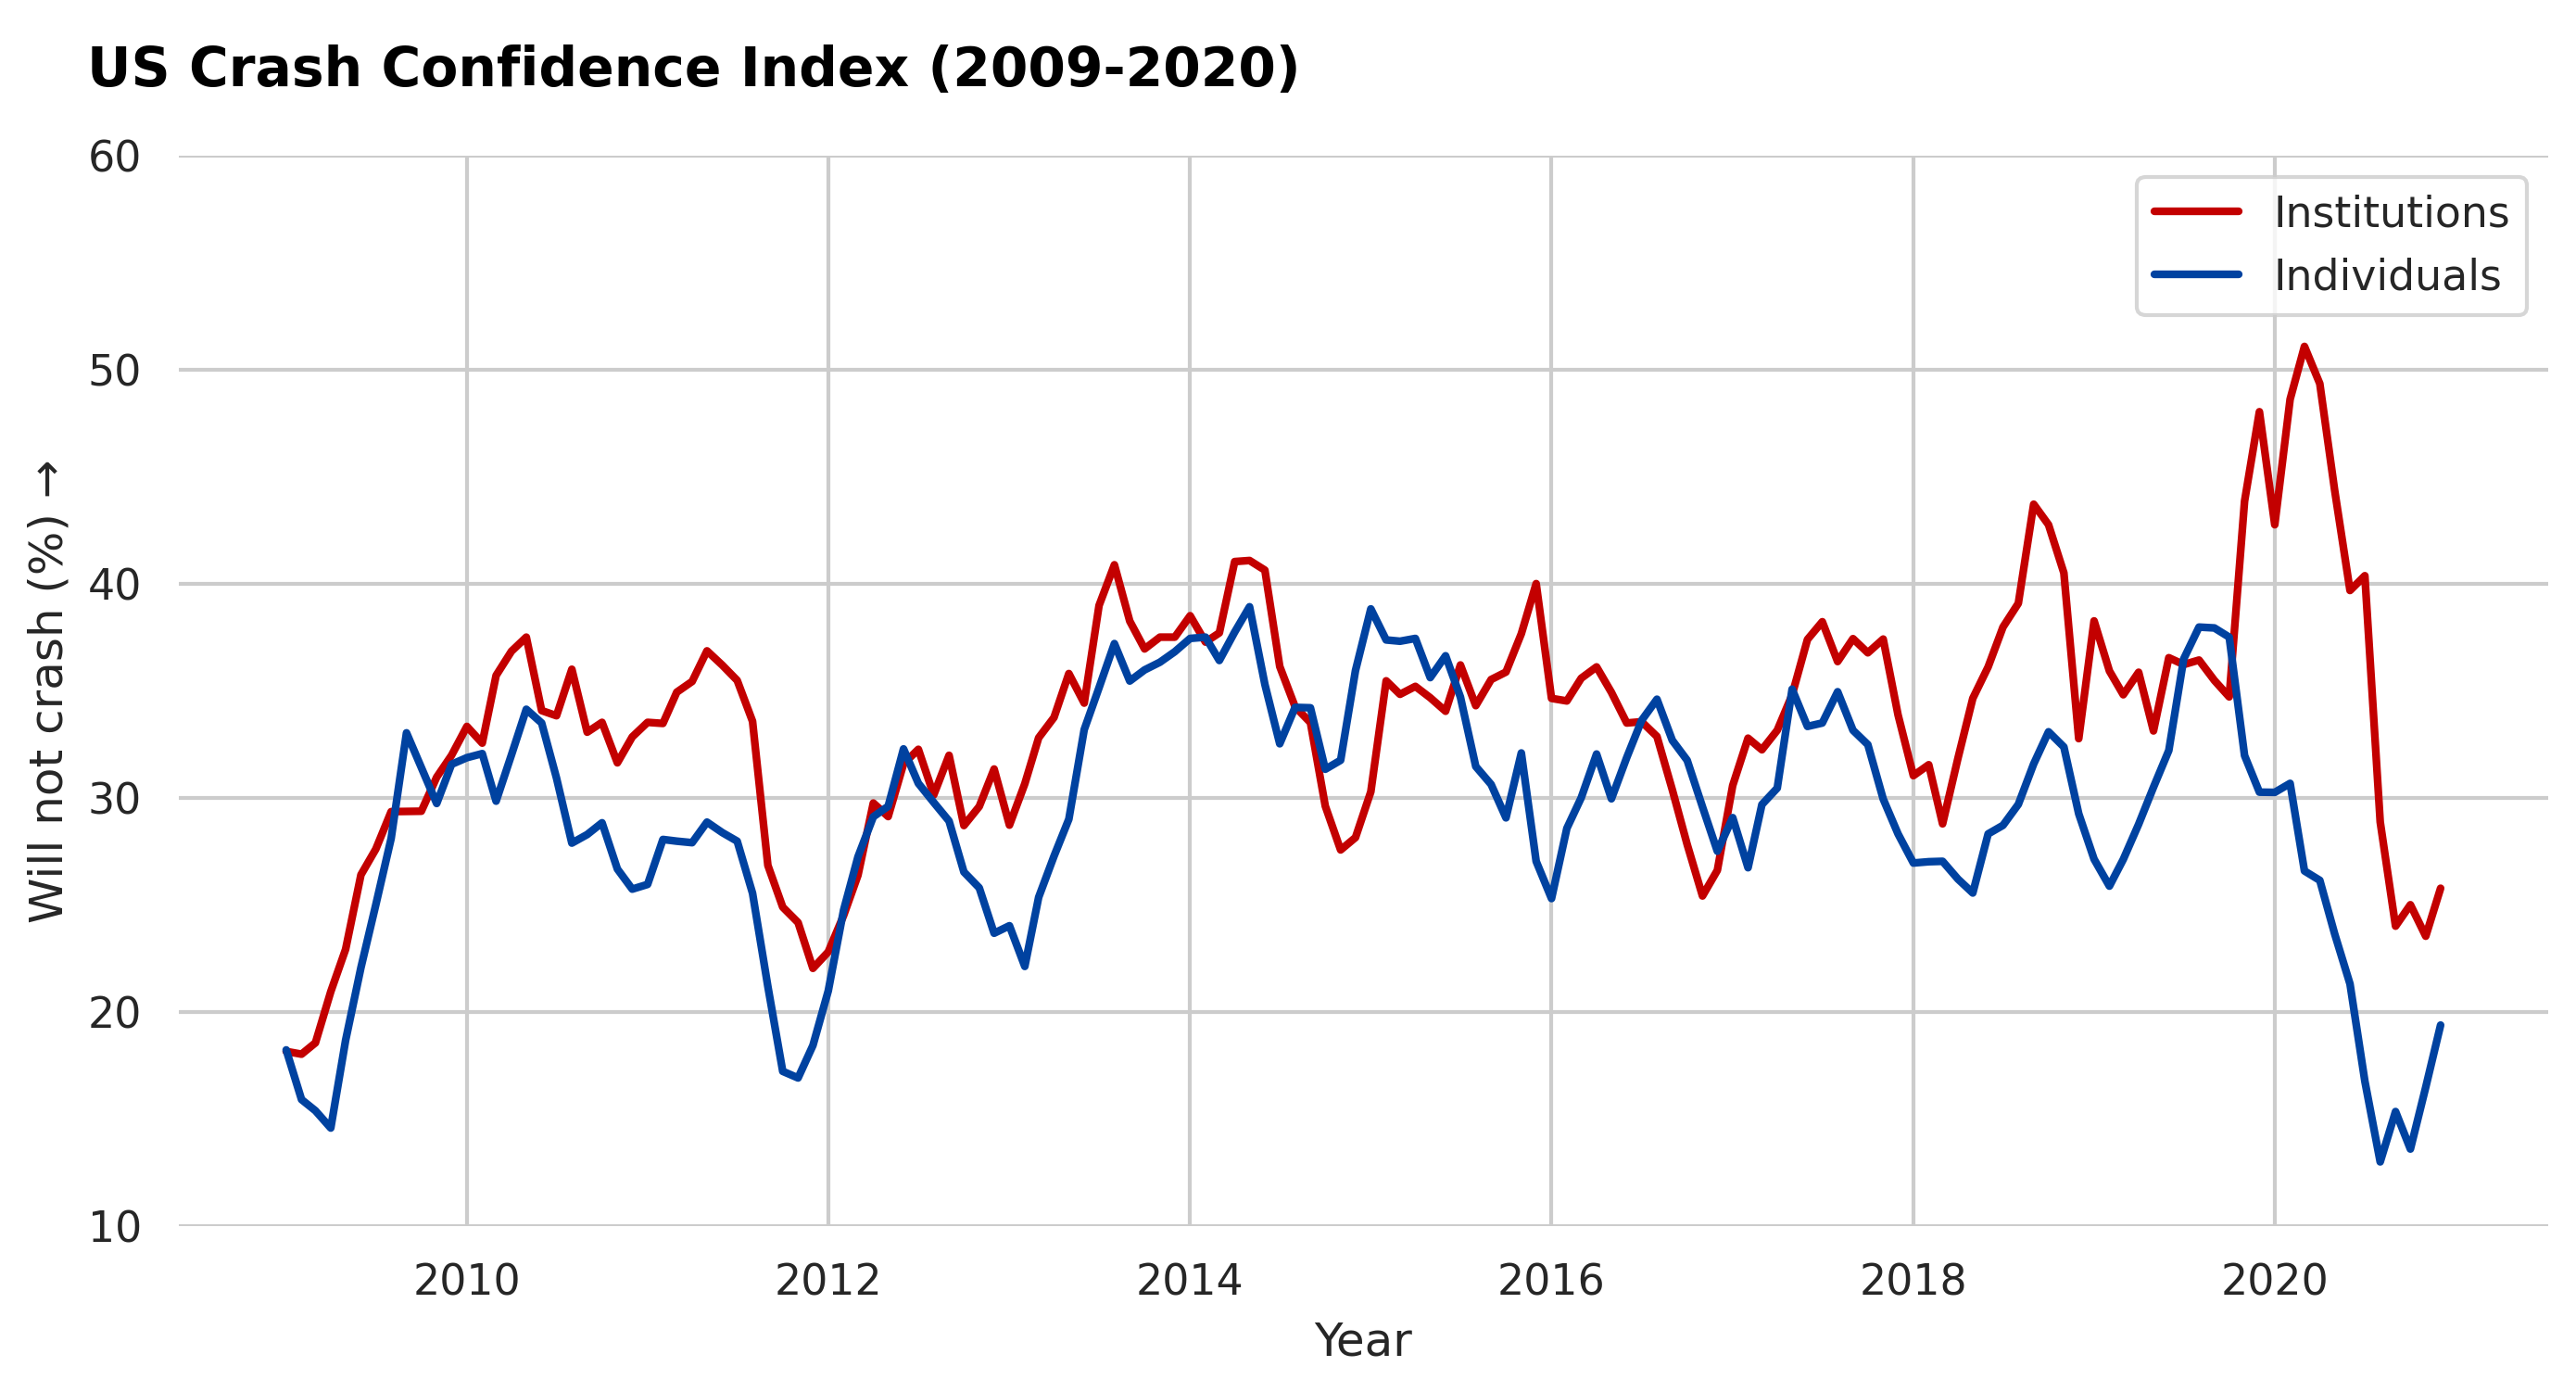

In [ ]:
icf_crash_filtered = icf_crash[(icf_crash['year'] >= 2009) & (icf_crash['year'] <= 2020)]

#creating a figure
fig = plt.figure(dpi=300)
fig.set_figheight(5)
fig.set_figwidth(11)
ax = plt.subplot()

ax.plot(
    icf_crash_filtered['date'],
    icf_crash_filtered['us_inst_crash'],
    label='Institutions',
    color='#C30000',
    linewidth=2.0
 )

ax.plot(
    icf_crash_filtered['date'],
    icf_crash_filtered['us_ind_crash'],
    label='Individuals',
    color='#0042A0',
    linewidth=2.0
 )


ax.spines["top"].set(visible = False)
ax.spines["bottom"].set(visible = False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

fig_text(
        x=0.095,y=0.96,
        s="US Crash Confidence Index (2009-2020)",
        size=14,
        color="black",
        weight="bold",
        annotationbbox_kw={"xycoords": "figure fraction"})
ax.set_xlabel('Year')
ax.set_ylabel('Will not crash (%) →')
ax.set(ylim=(10, 60))
ax.legend()

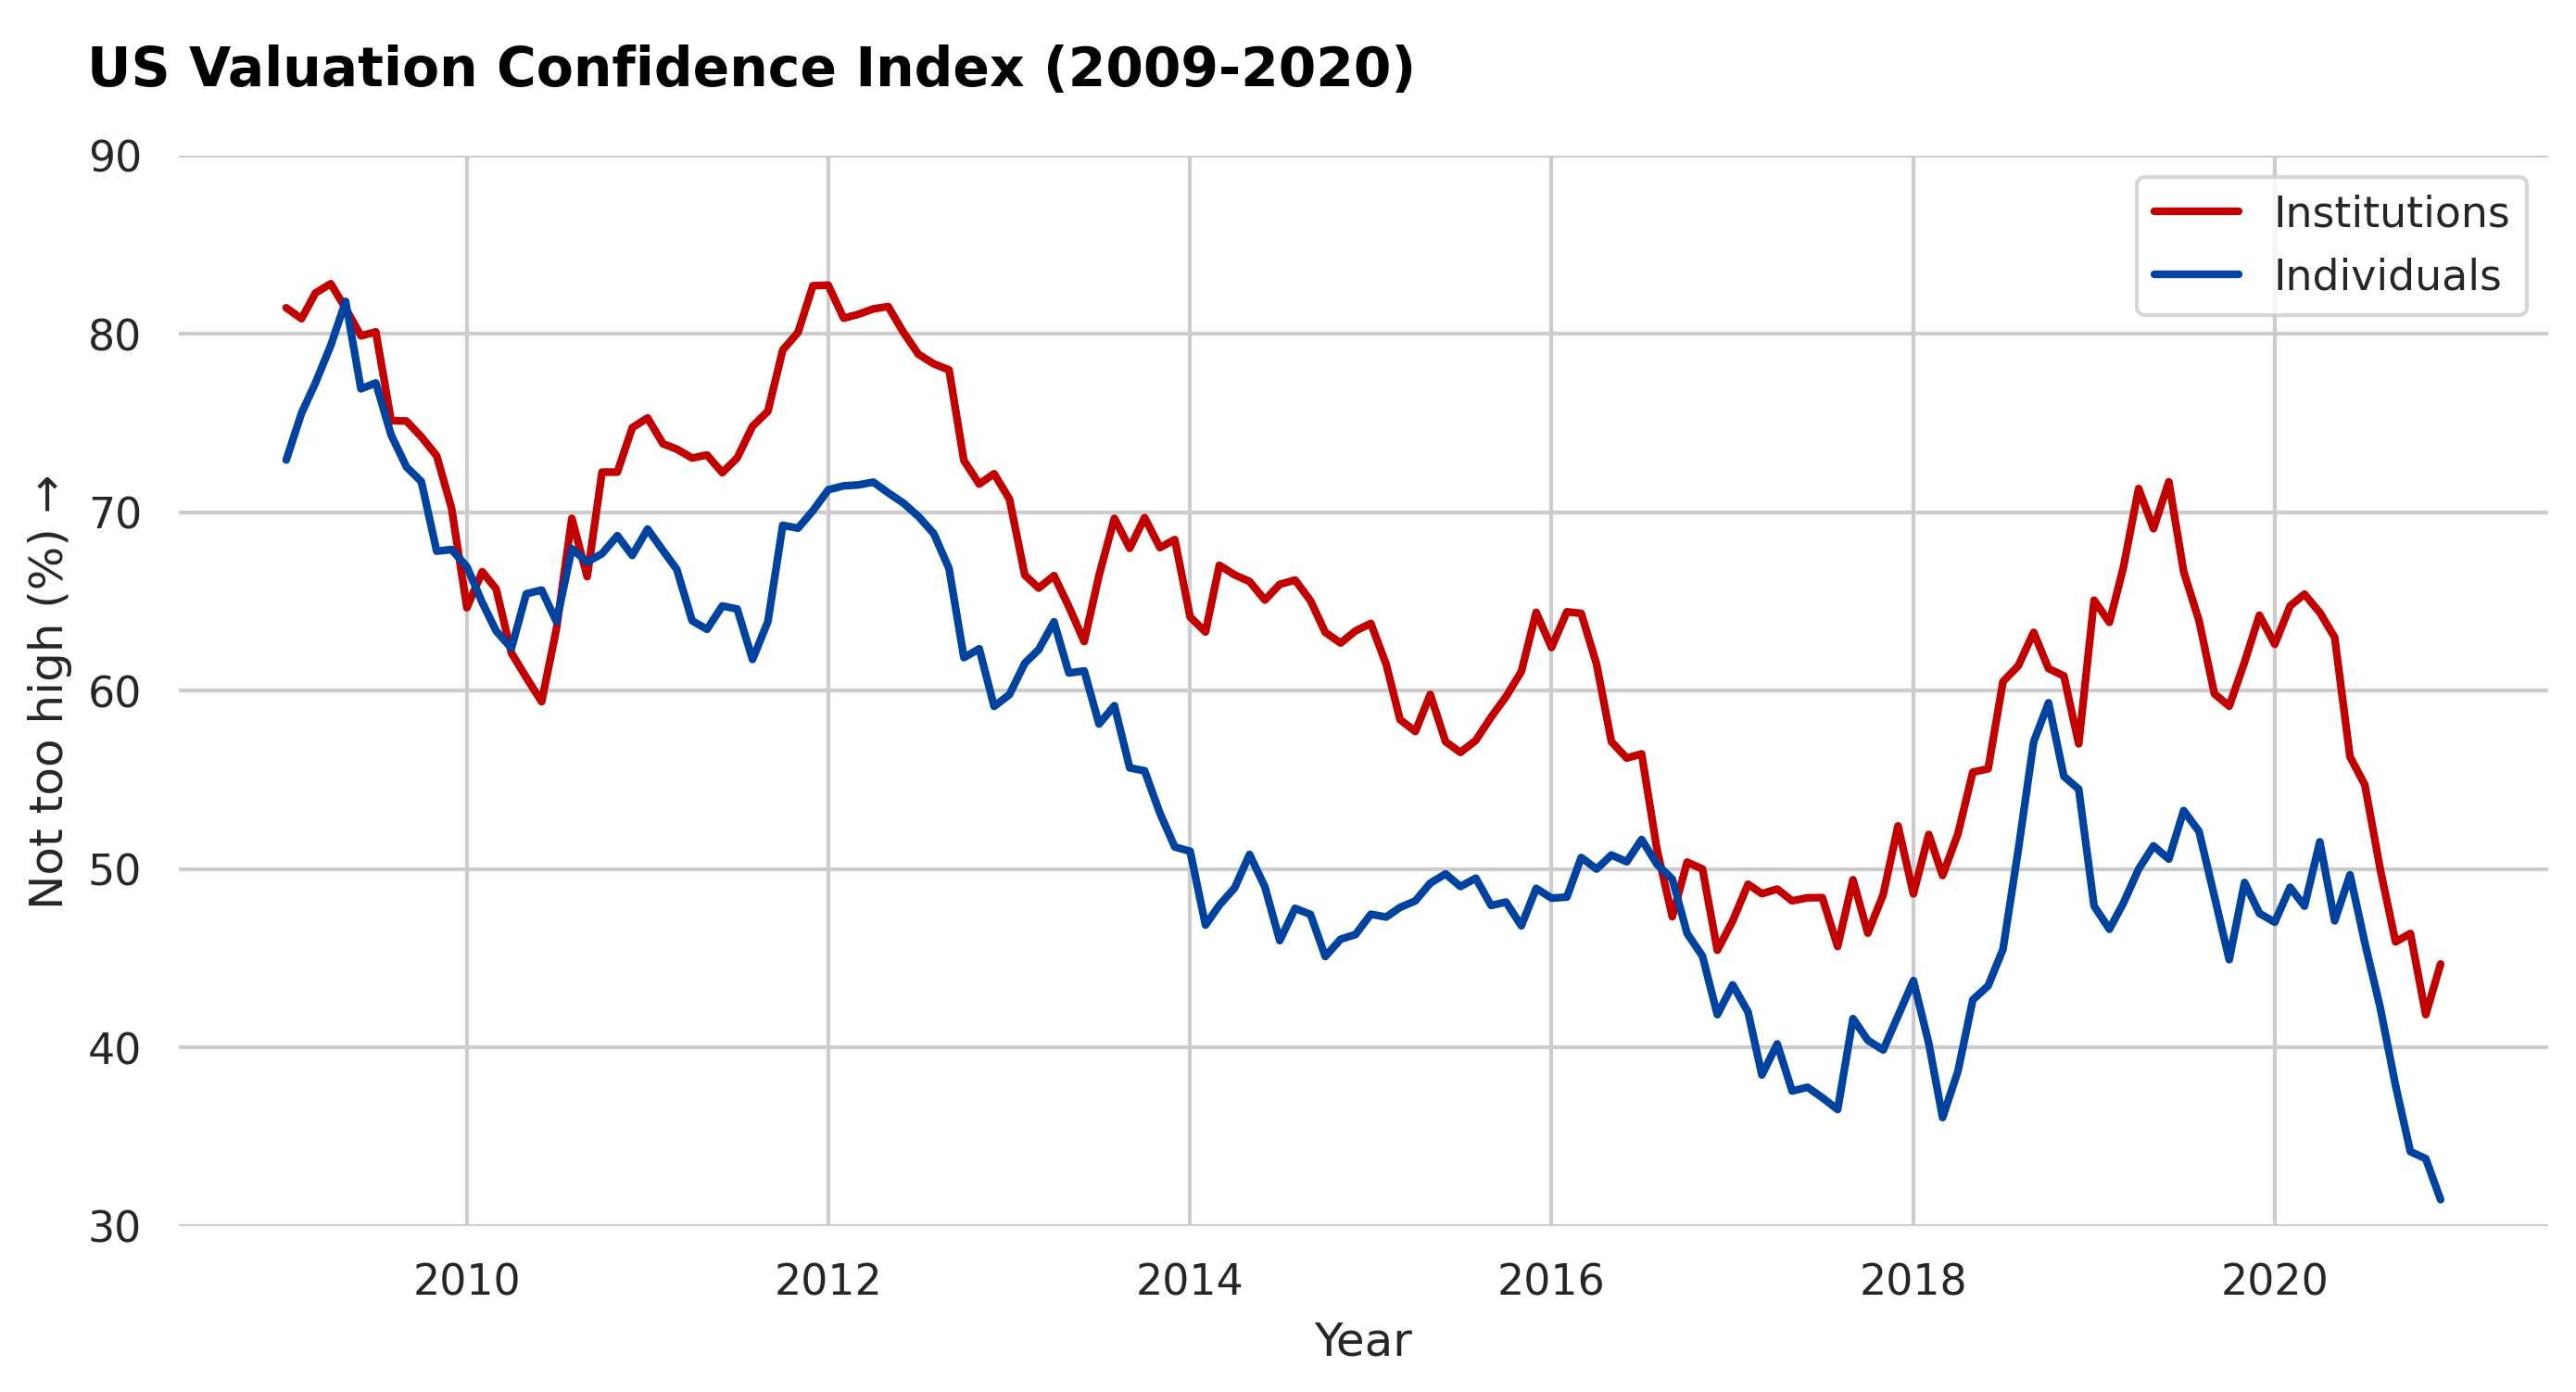

In [ ]:
icf_valuation_filtered = icf_valuation[(icf_valuation['year'] >= 2009) & (icf_valuation['year'] <= 2020)]

#creating a figure
fig = plt.figure(dpi=300)
fig.set_figheight(5)
fig.set_figwidth(11)
ax = plt.subplot()

ax.plot(
    icf_valuation_filtered['date'],
    icf_valuation_filtered['us_inst_valuation'],
    label='Institutions',
    color='#C30000',
    linewidth=2.0
 )

ax.plot(
    icf_valuation_filtered['date'],
    icf_valuation_filtered['us_ind_valuation'],
    label='Individuals',
    color='#0042A0',
    linewidth=2.0
 )


ax.spines["top"].set(visible = False)
ax.spines["bottom"].set(visible = False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

fig_text(
        x=0.095,y=0.96,
        s="US Valuation Confidence Index (2009-2020)",
        size=14,
        color="black",
        weight="bold",
        annotationbbox_kw={"xycoords": "figure fraction"})
ax.set_xlabel('Year')
ax.set_ylabel('Not too high (%) →')
ax.set(ylim=(30, 90))
ax.legend()


In [ ]:
# Merge icf_crash and icf_value with fin_monthly_df
fin_monthly_df = fin_monthly_df.merge(icf_crash[['year', 'month', 'us_inst_crash', 'us_ind_crash']], on=['year', 'month'], how='left')
fin_monthly_df = fin_monthly_df.merge(icf_valuation[['year', 'month', 'us_inst_valuation', 'us_ind_valuation']], on=['year', 'month'], how='left')

## 1.4 Merging OHLC and Fundamentals

In [ ]:
compare_columns(fin_monthly_df, ohlc_monthly_df, 'TICKER', 'tic')

Common elements in df1.TICKER and df2.tic: 31
Elements in df1.TICKER but not in df2.tic: {nan, 'FISV'}
Elements in df2.tic but not in df1.TICKER: set()


In [ ]:
fin_monthly_df = fin_monthly_df[fin_monthly_df['TICKER'] != 'FISV']

In [ ]:
fin_monthly_df.dropna(subset=['TICKER', 'gvkey', 'permno'], how="all", inplace=True)

In [ ]:
# Left join 'data' to 'ohlc_monthly' by 'gvkey' and 'public_date' where 'public_date' corresponds to 'date' in the ohlc_monthly dataframe
fin_monthly_df['permno'] = fin_monthly_df['permno'].astype(int)
for col in ['gvkey', 'month', 'year']:
  fin_monthly_df[col] = fin_monthly_df[col].astype(int)
  ohlc_monthly_df[col] = ohlc_monthly_df[col].astype(int)

# Merge the dataframes
merged_df = fin_monthly_df.merge(ohlc_monthly_df, left_on=['gvkey', 'month', 'year'], right_on=['gvkey', 'month', 'year'], suffixes=('_fin', '_ohlc'))
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             3720 non-null   object        
 1   date_fin           3720 non-null   datetime64[ns]
 2   gvkey              3720 non-null   int64         
 3   permno             3720 non-null   int64         
 4   CAPEI              3716 non-null   float64       
 5   bm                 3714 non-null   float64       
 6   evm                3719 non-null   float64       
 7   pe_op_basic        3719 non-null   float64       
 8   pe_op_dil          3719 non-null   float64       
 9   pe_exi             3719 non-null   float64       
 10  pe_inc             3719 non-null   float64       
 11  ps                 3719 non-null   float64       
 12  pcf                3719 non-null   float64       
 13  dpr                3440 non-null   float64       
 14  npm     

# 2. Patent Data

In [ ]:
kpss_df = pd.read_csv('/content/drive/MyDrive/thesis_data/KPSS_2020_public.csv', header=0)
kpss_df

,patent_num,xi_real,xi_nominal,cites,permno,issue_date,filing_date
0,1568057,1.704306,0.301662,10,14082,01/05/1926,06/23/1920
1,1568124,0.874477,0.154782,0,12503,01/05/1926,06/12/1920
2,1568134,0.874477,0.154782,0,12503,01/05/1926,09/09/1922
3,1568141,1.972018,0.349047,2,10401,01/05/1926,08/13/1920
4,1568142,1.972018,0.349047,1,10401,01/05/1926,08/13/1920
...,...,...,...,...,...,...,...
3053006,10881030,2.449192,6.379509,0,27828,12/29/2020,10/04/2019
3053007,10881031,30.225767,78.730263,0,90857,12/29/2020,09/18/2018
3053008,10881032,52.710850,137.298070,0,88519,12/29/2020,03/09/2017
3053009,10881036,16.260132,42.353413,0,76076,12/29/2020,03/04/2019


In [ ]:
# Remove patents issued to non-sample companies
kpss_df['issue_date'] = pd.to_datetime(kpss_df['issue_date'],format='%m/%d/%Y')
kpss_df['filing_date'] = pd.to_datetime(kpss_df['filing_date'],format='%m/%d/%Y')

# keep only those 'issue_date' which are between 2010-01-01 and 2019-12-31
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2019-12-31')
kpss_df = kpss_df[(kpss_df['issue_date'] >= start_date) & (kpss_df['issue_date'] <= end_date)]

# kpss_df = kpss_df[kpss_df['permno'].isin(merged_df.permno.unique())]  # Filter dataframe based on index.permno
kpss_df.reset_index(inplace=True)

In [ ]:
# use kpss_df to create a kpss_monthly_df which is the monthly sum for the columns xi_nominal xi_real cites grouped by permno with a new date column which is the last date of the month specified
# Extract year and month from 'issue_date'
kpss_df['year'] = kpss_df['issue_date'].dt.year
kpss_df['month'] = kpss_df['issue_date'].dt.month
kpss_df['spc'] = 1
# Group by 'permno', 'year', and 'month' and sum the relevant columns
kpss_monthly_df = kpss_df.groupby(['permno', 'year', 'month'])[['xi_nominal', 'xi_real', 'cites', 'spc']].sum().reset_index()
kpss_monthly_df = kpss_monthly_df.rename(columns={'cites': 'wpc'})
# Create a 'date' column representing the last day of each month
kpss_monthly_df['date'] = pd.to_datetime(kpss_monthly_df['year'].astype(str) + '-' + kpss_monthly_df['month'].astype(str)) + pd.offsets.MonthEnd(0)
# kpss_monthly_df.set_index('date', inplace=True)
kpss_monthly_df.info()

<ipython-input-59-e7fba55b68ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpss_df['year'] = kpss_df['issue_date'].dt.year
<ipython-input-59-e7fba55b68ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpss_df['month'] = kpss_df['issue_date'].dt.month
<ipython-input-59-e7fba55b68ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72592 entries, 0 to 72591
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   permno      72592 non-null  int64         
 1   year        72592 non-null  int32         
 2   month       72592 non-null  int32         
 3   xi_nominal  72592 non-null  float64       
 4   xi_real     72592 non-null  float64       
 5   wpc         72592 non-null  int64         
 6   spc         72592 non-null  int64         
 7   date        72592 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), int64(3)
memory usage: 3.9 MB


In [ ]:
# Create a dictionary mapping permno to gvkey from the merged_df DataFrame
permno_to_gvkey = dict(zip(merged_df['permno'], merged_df['gvkey']))

# Map the 'gvkey' values to the 'tic' column in ohlc_monthly
kpss_monthly_df['gvkey'] = kpss_monthly_df['permno'].map(permno_to_gvkey)
kpss_monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72592 entries, 0 to 72591
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   permno      72592 non-null  int64         
 1   year        72592 non-null  int32         
 2   month       72592 non-null  int32         
 3   xi_nominal  72592 non-null  float64       
 4   xi_real     72592 non-null  float64       
 5   wpc         72592 non-null  int64         
 6   spc         72592 non-null  int64         
 7   date        72592 non-null  datetime64[ns]
 8   gvkey       2961 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(2), int64(3)
memory usage: 4.4 MB


# FINAL MERGE

In [ ]:
final_merged_df = merged_df.merge(kpss_monthly_df, left_on=['gvkey', 'month', 'year'], right_on=['gvkey', 'month', 'year'], how="left", suffixes=('fin', '_kpss'))

In [ ]:
final_merged_df.groupby('TICKER')['year'].value_counts()[50:80]

TICKER  year
AMD     2016    12
        2015    12
        2014    12
        2013    12
        2012    12
        2011    12
        2010    12
        2017    12
        2018    12
        2019    12
AMGN    2010    12
        2019    12
        2018    12
        2017    12
        2016    12
        2015    12
        2014    12
        2013    12
        2012    12
        2011    12
ANSS    2015    12
        2014    12
        2013    12
        2012    12
        2011    12
        2010    12
        2016    12
        2017    12
        2018    12
        2019    12
Name: count, dtype: int64

In [ ]:
col = 'roce'
missing_counts = final_merged_df.groupby('TICKER')[col].apply(lambda x: x.isnull().sum()).reset_index(name='missing_count')
print(missing_counts)

   TICKER  missing_count
0    AAPL              0
1    ADBE              0
2     ADI              0
3    ALGN              0
4    AMAT              0
5     AMD              0
6    AMGN              0
7    ANSS              0
8    CSCO              0
9    CTSH              0
10   DXCM              0
11   FTNT              1
12  GOOGL              0
13   IDXX              0
14   ILMN              0
15   INTC              0
16   INTU              0
17   ISRG              0
18   KLAC              0
19   LRCX              0
20   MCHP              0
21   MSFT              0
22   NFLX              0
23   NVDA              0
24   PAYX              0
25   QCOM              0
26   REGN              0
27   SGEN              0
28   SNPS             32
29    TXN              0
30   VRSN              0


# 3. Final Touches

In [ ]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 67 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             3720 non-null   object        
 1   date_fin           3720 non-null   datetime64[ns]
 2   gvkey              3720 non-null   int64         
 3   permnofin          3720 non-null   int64         
 4   CAPEI              3716 non-null   float64       
 5   bm                 3714 non-null   float64       
 6   evm                3719 non-null   float64       
 7   pe_op_basic        3719 non-null   float64       
 8   pe_op_dil          3719 non-null   float64       
 9   pe_exi             3719 non-null   float64       
 10  pe_inc             3719 non-null   float64       
 11  ps                 3719 non-null   float64       
 12  pcf                3719 non-null   float64       
 13  dpr                3440 non-null   float64       
 14  npm     

In [ ]:
# prompt: Drop rows with TICKER is FTNT

final_merged_df = final_merged_df[final_merged_df['TICKER'] != 'FTNT']
final_merged_df.TICKER.nunique()

30

In [ ]:
print(missing_value_percent(final_merged_df).sort_values(ascending=False)[:20])

divyield             53.888889
inv_turn             24.555556
spc                  20.833333
wpc                  20.833333
xi_real              20.833333
xi_nominal           20.833333
permno_kpss          20.833333
date                 20.833333
efftax                8.805556
dpr                   7.750000
PEG_trailing          5.611111
rect_turn             3.027778
roce                  0.888889
capital_ratio         0.805556
debt_invcap           0.805556
totdebt_invcap        0.805556
ptb                   0.138889
bm                    0.138889
sale_equity           0.138889
us_inst_valuation     0.000000
dtype: float64


In [ ]:
# PATENT INFO CLEAN UP
# Fill missing values in 'cites', 'xi_real', and 'xi_nominal' with 0
final_merged_df['wpc'].fillna(0, inplace=True)
final_merged_df['xi_real'].fillna(0, inplace=True)
final_merged_df['xi_nominal'].fillna(0, inplace=True)
final_merged_df['spc'].fillna(0, inplace=True)
final_merged_df = final_merged_df.drop(['date', 'permno_kpss', 'date_ohlc', 'tic', 'month', 'year', 'cusip', 'prchd', 'prcld', 'prcod'], axis=1)


In [ ]:
# Dropping inventory turnover
final_merged_df = final_merged_df.drop(['inv_turn', 'efftax','PEG_trailing', 'sale_equity', 'ptb'], axis=1)

fill_0 = ['dpr', 'divyield']
# Fill dividend payout rato and yield as 0 for missing
for col in fill_0:
  final_merged_df[col].fillna(0, inplace=True)

# Apply the function to the 'divyield' column
final_merged_df['divyield'] = final_merged_df['divyield'].apply(convert_percentage_to_float)

In [ ]:
fill_0 = ['rect_turn','bm']
for col in fill_0:
  final_merged_df[col].fillna(0, inplace=True)

In [ ]:
final_merged_df.loc[final_merged_df['TICKER']=='SNPS', ['totdebt_invcap','debt_invcap','capital_ratio']]

,totdebt_invcap,debt_invcap,capital_ratio
3360,NaN,NaN,NaN
3361,NaN,NaN,NaN
3362,NaN,NaN,NaN
3363,NaN,NaN,NaN
3364,NaN,NaN,NaN
...,...,...,...
3475,0.130,0.034,0.034
3476,0.092,0.032,0.032
3477,0.092,0.032,0.032
3478,0.092,0.032,0.032


In [ ]:
final_merged_df.head()

,TICKER,date_fin,gvkey,permnofin,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,...,us_inst_valuation,us_ind_valuation,cshoc,cshtrd,prccd,market_value,xi_nominal,xi_real,wpc,spc
0,AAPL,2010-01-31,1690,14593,43.783,0.203,13.424,20.831,21.152,21.152,...,64.65,66.95,9.060901e+08,2.837278e+07,207.715737,1.882072e+11,3290.902098,1501.467844,1661.0,37.0
1,AAPL,2010-02-28,1690,14593,48.834,0.202,10.239,0.701,0.714,0.714,...,66.67,64.94,9.067950e+08,2.019496e+07,198.795000,1.802663e+11,3146.213446,1435.453871,3524.0,33.0
2,AAPL,2010-03-31,1690,14593,56.260,0.202,10.239,0.805,0.820,0.820,...,65.70,63.35,9.067950e+08,1.880575e+07,223.410648,2.025877e+11,4466.365840,2037.770799,984.0,40.0
3,AAPL,2010-04-30,1690,14593,62.527,0.202,10.239,0.894,0.911,0.911,...,62.11,62.38,9.078427e+08,2.094627e+07,251.148548,2.280187e+11,4213.516131,1922.408658,984.0,47.0
4,AAPL,2010-05-31,1690,14593,54.324,0.199,11.041,0.765,0.779,0.779,...,60.74,65.43,9.099380e+08,3.221138e+07,251.461200,2.288141e+11,4046.137234,1846.042431,886.0,43.0


In [ ]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3600 entries, 0 to 3719
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             3600 non-null   object        
 1   date_fin           3600 non-null   datetime64[ns]
 2   gvkey              3600 non-null   int64         
 3   permnofin          3600 non-null   int64         
 4   CAPEI              3600 non-null   float64       
 5   bm                 3600 non-null   float64       
 6   evm                3600 non-null   float64       
 7   pe_op_basic        3600 non-null   float64       
 8   pe_op_dil          3600 non-null   float64       
 9   pe_exi             3600 non-null   float64       
 10  pe_inc             3600 non-null   float64       
 11  ps                 3600 non-null   float64       
 12  pcf                3600 non-null   float64       
 13  dpr                3600 non-null   float64       
 14  npm          

In [ ]:
final_merged_df = final_merged_df.set_index(['TICKER', 'date_fin'])

cols = ['totdebt_invcap', 'debt_invcap', 'capital_ratio', 'roce']

for col in cols:
  final_merged_df[col] = final_merged_df.groupby(level=0)[col].transform(lambda x: x.interpolate(method='linear', order=1, limit_direction='backward', limit_area='outside'))

final_merged_df = final_merged_df.reset_index()
# final_merged_df.drop(['level_0',	'index'], axis=1, inplace=True)

# Output

In [ ]:
final_merged_df.to_csv('/content/drive/MyDrive/thesis_data/final_v3.csv', index=False)